In [1]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, cohen_kappa_score)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F

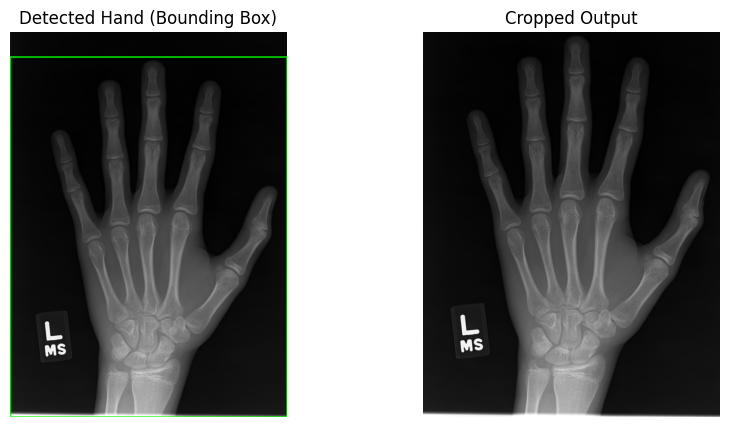

In [9]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_crop_hand(image_path, visualize=False):
    """
    Simulates an Object Detection Model using Computer Vision.
    1. Loads image.
    2. Thresholds to find the Hand object.
    3. Crops the image to the hand's bounding box.
    """
    # [OPERATION] Load Image in Grayscale for Detection
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    
    # [OPERATION] Preprocessing for Detection: Blur to remove noise
    # This helps the thresholding algorithm ignore small specs of dust/text
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # [OPERATION] Object Detection: Thresholding
    # Binary thresholding separates the hand (foreground) from background
    # 30 is a safe threshold for X-rays (bones are bright)
    _, thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)
    
    # [OPERATION] Find Contours (The "Objects")
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return img # Return original if detection fails
        
    # [OPERATION] Select Largest Object (The Hand)
    # The hand is always the largest contiguous object in these X-rays
    c = max(contours, key=cv2.contourArea)
    
    # [OPERATION] Get Bounding Box
    x, y, w, h = cv2.boundingRect(c)
    
    # [OPERATION] Add Margin (Padding)
    # We don't want to crop exactly at the skin edge; give it some breathing room
    height, width = img.shape
    margin = 20
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(width - x, w + 2*margin)
    h = min(height - y, h + 2*margin)
    
    # [OPERATION] Crop
    cropped_img = img[y:y+h, x:x+w]
    
    # Visualization (Only for debugging/demo)
    if visualize:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 255, 0), 5) # Draw Box
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Detected Hand (Bounding Box)")
        plt.imshow(img_color)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title("Cropped Output")
        plt.imshow(cropped_img, cmap='gray')
        plt.axis('off')
        plt.show()
        
    return cropped_img

sample_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/10063.png'


_ = detect_and_crop_hand(sample_path, visualize=True)

In [10]:
# ==========================================
# 1. CONFIGURATION & REPRODUCIBILITY
# ==========================================
CONFIG = {
    'seed': 42,
    'img_size': 384,        # Larger size for better bone detail
    'batch_size': 32,       # Per GPU (Total effective = 64 on 2xT4)
    'epochs': 15,
    'lr': 1e-4,
    'num_workers': 4,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'data_dir': '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset',
    'csv_path': '/kaggle/input/rsna-bone-age/boneage-training-dataset.csv'
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG['seed'])
print(f"Using Device: {CONFIG['device']}")
if torch.cuda.device_count() > 1:
    print(f"GPUs available: {torch.cuda.device_count()} (Training will be distributed)")

Using Device: cuda
GPUs available: 2 (Training will be distributed)


In [11]:
# ==========================================
# 2. DATA PREPROCESSING & GENERATION
# ==========================================

# Load CSV
df = pd.read_csv(CONFIG['csv_path'])

# [PREPROCESSING] 1. Create Classification Bins (Developmental Stages)
# We define 4 stages based on months: 
# 0-3 yrs (0-36m), 3-10 yrs (36-120m), 10-15 yrs (120-180m), 15+ yrs (>180m)
def assign_stage(months):
    if months < 36: return 0  # Toddler
    elif months < 120: return 1 # Pre-Puberty
    elif months < 180: return 2 # Puberty
    else: return 3 # Young Adult

df['age_class'] = df['boneage'].apply(assign_stage)
class_names = ['Toddler', 'Pre-Puberty', 'Puberty', 'Young Adult']

# [PREPROCESSING] 2. Encode Gender (Male=1, Female=0)
# This is crucial as bone ossification differs by sex.
df['sex_encoded'] = df['male'].apply(lambda x: 1 if x else 0) 

# [PREPROCESSING] 3. File Path Creation
# Construct full path to images to facilitate loading
df['path'] = df['id'].apply(lambda x: os.path.join(CONFIG['data_dir'], f"{x}.png"))

# [PREPROCESSING] 4. Train/Val/Test Split (70/15/15)
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=CONFIG['seed'], stratify=df['age_class'])
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=CONFIG['seed'], stratify=test_val_df['age_class'])

print(f"Train Size: {len(train_df)} | Val Size: {len(val_df)} | Test Size: {len(test_df)}")

Train Size: 8827 | Val Size: 1892 | Test Size: 1892


In [12]:
# ==========================================
# 3. DATASET & TRANSFORMS
# ==========================================

class BoneAgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        
        # [OPERATION] Load Image
        image = Image.open(image_path).convert("RGB")
        
        # [OPERATION] Apply Preprocessing Transforms (Resize, Crop, Normalize)
        if self.transform:
            image = self.transform(image)
            
        # [OPERATION] Extract Metadata
        # Gender is essentially a feature vector of size 1
        gender = torch.tensor([row['sex_encoded']], dtype=torch.float32)
        
        # Targets
        age_reg = torch.tensor(row['boneage'], dtype=torch.float32) # Regression Target
        age_cls = torch.tensor(row['age_class'], dtype=torch.long)  # Classification Target
        
        return image, gender, age_reg, age_cls

# Define Transforms
# [NOTE] Preprocessing steps happen here automatically during data loading
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])), # [RESIZE]
    transforms.RandomHorizontalFlip(), # [AUGMENTATION]
    transforms.RandomRotation(15),     # [AUGMENTATION] - Helps generalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # [NORMALIZATION]
])

val_test_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])), # [RESIZE]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders
train_dataset = BoneAgeDataset(train_df, transform=train_transform)
val_dataset = BoneAgeDataset(val_df, transform=val_test_transform)
test_dataset = BoneAgeDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])


In [13]:
# ==========================================
# 4. MODEL ARCHITECTURE (Hybrid Regression + Classification)
# ==========================================

class BoneAgePredictor(nn.Module):
    def __init__(self, num_classes=4):
        super(BoneAgePredictor, self).__init__()
        # Backbone: ResNet50
        self.backbone = models.resnet50(pretrained=True)
        
        # Feature Extraction layer size
        num_features = self.backbone.fc.in_features
        
        # Remove original FC layer
        self.backbone.fc = nn.Identity()
        
        # Fusion Layer: Image Features + Gender
        self.fusion_dim = num_features + 1 # +1 for gender
        
        self.fc1 = nn.Linear(self.fusion_dim, 1024)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
        # HEAD 1: Regression (Predict Age in Months)
        self.reg_head = nn.Linear(1024, 1)
        
        # HEAD 2: Classification (Predict Stage)
        self.cls_head = nn.Linear(1024, num_classes)
        
    def forward(self, image, gender):
        # Extract visual features
        x = self.backbone(image)
        
        # [OPERATION] Flatten if necessary (ResNet outputs flat vector usually after Identity)
        x = x.view(x.size(0), -1)
        
        # [OPERATION] Feature Concatenation (Image + Gender)
        x = torch.cat((x, gender), dim=1)
        
        # Dense layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Outputs
        age_pred = self.reg_head(x)
        class_pred = self.cls_head(x)
        
        return age_pred, class_pred

# Initialize Model
model = BoneAgePredictor(num_classes=4)

# [CRITICAL FOR KAGGLE] Wrap in DataParallel to use both T4 GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(CONFIG['device'])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


In [16]:
# ==========================================
# 5. TRAINING LOOP (WITH FULL METRICS)
# ==========================================

# Losses
criterion_reg = nn.L1Loss() 
criterion_cls = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])
# Removed verbose=True to fix warning
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def compute_metrics_batch(y_true_reg, y_pred_reg, y_true_cls, y_pred_cls):
    """Helper to compute all metrics for a set of predictions"""
    # Regression Metrics
    mae = mean_absolute_error(y_true_reg, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_true_reg, y_pred_reg))
    r2 = r2_score(y_true_reg, y_pred_reg)
    
    # Classification Metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)
    # Weighted average handles class imbalance
    prec = precision_score(y_true_cls, y_pred_cls, average='weighted', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, average='weighted', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, average='weighted', zero_division=0)
    qwk = cohen_kappa_score(y_true_cls, y_pred_cls, weights='quadratic')
    
    return {
        "MAE": mae, "RMSE": rmse, "R2": r2,
        "Acc": acc, "Prec": prec, "Rec": rec, "F1": f1, "QWK": qwk
    }

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss_total = 0.0
    running_loss_reg = 0.0
    running_loss_cls = 0.0
    
    # Storage for metrics
    all_preds_reg = []
    all_targets_reg = []
    all_preds_cls = []
    all_targets_cls = []
    
    for images, genders, ages, classes in loader:
        images, genders = images.to(CONFIG['device']), genders.to(CONFIG['device'])
        ages, classes = ages.to(CONFIG['device']), classes.to(CONFIG['device'])
        
        optimizer.zero_grad()
        
        # Forward pass
        pred_age, pred_cls = model(images, genders)
        
        # Calculate Losses
        loss_reg = criterion_reg(pred_age.view(-1), ages)
        loss_cls = criterion_cls(pred_cls, classes)
        total_loss = loss_reg + (0.5 * loss_cls)
        
        total_loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Track Losses
        running_loss_total += total_loss.item()
        running_loss_reg += loss_reg.item()
        running_loss_cls += loss_cls.item()
        
        # Track Predictions for Metrics
        all_preds_reg.extend(pred_age.view(-1).detach().cpu().numpy())
        all_targets_reg.extend(ages.cpu().numpy())
        
        # Get class predictions (argmax)
        _, cls_preds_indices = torch.max(pred_cls, 1)
        all_preds_cls.extend(cls_preds_indices.detach().cpu().numpy())
        all_targets_cls.extend(classes.cpu().numpy())
        
    # Calculate Epoch Metrics
    metrics = compute_metrics_batch(all_targets_reg, all_preds_reg, all_targets_cls, all_preds_cls)
    
    # Add average losses to metrics dict
    metrics['Loss_Total'] = running_loss_total / len(loader)
    metrics['Loss_Reg'] = running_loss_reg / len(loader)
    metrics['Loss_Cls'] = running_loss_cls / len(loader)
    
    return metrics

def validate(model, loader):
    model.eval()
    running_loss_total = 0.0
    running_loss_reg = 0.0
    running_loss_cls = 0.0
    
    all_preds_reg = []
    all_targets_reg = []
    all_preds_cls = []
    all_targets_cls = []
    
    with torch.no_grad():
        for images, genders, ages, classes in loader:
            images, genders = images.to(CONFIG['device']), genders.to(CONFIG['device'])
            ages, classes = ages.to(CONFIG['device']), classes.to(CONFIG['device'])
            
            pred_age, pred_cls = model(images, genders)
            
            loss_reg = criterion_reg(pred_age.view(-1), ages)
            loss_cls = criterion_cls(pred_cls, classes)
            total_loss = loss_reg + (0.5 * loss_cls)
            
            running_loss_total += total_loss.item()
            running_loss_reg += loss_reg.item()
            running_loss_cls += loss_cls.item()
            
            all_preds_reg.extend(pred_age.view(-1).cpu().numpy())
            all_targets_reg.extend(ages.cpu().numpy())
            
            _, cls_preds_indices = torch.max(pred_cls, 1)
            all_preds_cls.extend(cls_preds_indices.cpu().numpy())
            all_targets_cls.extend(classes.cpu().numpy())
            
    metrics = compute_metrics_batch(all_targets_reg, all_preds_reg, all_targets_cls, all_preds_cls)
    
    metrics['Loss_Total'] = running_loss_total / len(loader)
    metrics['Loss_Reg'] = running_loss_reg / len(loader)
    metrics['Loss_Cls'] = running_loss_cls / len(loader)
    
    return metrics

# --- MAIN LOOP ---
print("Starting Training with Detailed Metrics...")
start_time = time.time()
best_mae = float('inf')

for epoch in range(CONFIG['epochs']):
    # 1. Run Train & Val
    t_metrics = train_one_epoch(model, train_loader, optimizer)
    v_metrics = validate(model, val_loader)
    
    # 2. Scheduler Step (Monitor Validation MAE)
    scheduler.step(v_metrics['MAE'])
    
    # 3. Print Report
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']} | LR: {current_lr:.6f}")
    
    # Print Losses
    print(f"  LOSS  | Train: {t_metrics['Loss_Total']:.4f} (Reg: {t_metrics['Loss_Reg']:.2f}, Cls: {t_metrics['Loss_Cls']:.2f})")
    print(f"        | Val:   {v_metrics['Loss_Total']:.4f} (Reg: {v_metrics['Loss_Reg']:.2f}, Cls: {v_metrics['Loss_Cls']:.2f})")
    
    # Print Regression Metrics
    print(f"  REG   | Train MAE: {t_metrics['MAE']:.2f} | RMSE: {t_metrics['RMSE']:.2f} | R2: {t_metrics['R2']:.3f}")
    print(f"        | Val   MAE: {v_metrics['MAE']:.2f} | RMSE: {v_metrics['RMSE']:.2f} | R2: {v_metrics['R2']:.3f}")
    
    # Print Classification Metrics
    print(f"  CLASS | Train Acc: {t_metrics['Acc']:.3f} | F1: {t_metrics['F1']:.3f} | QWK: {t_metrics['QWK']:.3f}")
    print(f"        | Val   Acc: {v_metrics['Acc']:.3f} | F1: {v_metrics['F1']:.3f} | QWK: {v_metrics['QWK']:.3f}")

    # 4. Save Best Model
    if v_metrics['MAE'] < best_mae:
        best_mae = v_metrics['MAE']
        if isinstance(model, nn.DataParallel):
             torch.save(model.module.state_dict(), 'best_bone_age_model.pth')
        else:
             torch.save(model.state_dict(), 'best_bone_age_model.pth')
        print("  >>> [SAVED] New Best Model!")

print(f"\nTraining Complete in {(time.time() - start_time)/60:.2f} minutes")

Starting Training with Detailed Metrics...

Epoch 1/15 | LR: 0.000100
  LOSS  | Train: 14.4932 (Reg: 13.87, Cls: 1.25)
        | Val:   13.9532 (Reg: 13.61, Cls: 0.69)
  REG   | Train MAE: 13.87 | RMSE: 17.53 | R2: 0.818
        | Val   MAE: 13.59 | RMSE: 16.78 | R2: 0.835
  CLASS | Train Acc: 0.646 | F1: 0.640 | QWK: 0.482
        | Val   Acc: 0.800 | F1: 0.754 | QWK: 0.690
  >>> [SAVED] New Best Model!

Epoch 2/15 | LR: 0.000100
  LOSS  | Train: 13.2303 (Reg: 12.75, Cls: 0.96)
        | Val:   11.6320 (Reg: 11.45, Cls: 0.37)
  REG   | Train MAE: 12.75 | RMSE: 16.21 | R2: 0.844
        | Val   MAE: 11.33 | RMSE: 14.32 | R2: 0.880
  CLASS | Train Acc: 0.697 | F1: 0.687 | QWK: 0.581
        | Val   Acc: 0.861 | F1: 0.850 | QWK: 0.814
  >>> [SAVED] New Best Model!

Epoch 3/15 | LR: 0.000100
  LOSS  | Train: 12.1944 (Reg: 11.80, Cls: 0.78)
        | Val:   11.3803 (Reg: 11.14, Cls: 0.47)
  REG   | Train MAE: 11.80 | RMSE: 14.97 | R2: 0.867
        | Val   MAE: 11.20 | RMSE: 14.35 | R2: 0.

In [17]:
# ==========================================
# 6. FINAL EVALUATION & METRICS REPORT
# ==========================================

def calculate_metrics(model, loader):
    model.eval()
    
    # Regression lists
    y_true_reg = []
    y_pred_reg = []
    
    # Classification lists
    y_true_cls = []
    y_pred_cls = []
    
    with torch.no_grad():
        for images, genders, ages, classes in loader:
            images = images.to(CONFIG['device'])
            genders = genders.to(CONFIG['device'])
            
            p_age, p_cls = model(images, genders)
            
            # Collect Regression
            y_true_reg.extend(ages.numpy())
            y_pred_reg.extend(p_age.cpu().squeeze().numpy())
            
            # Collect Classification (Argmax for class)
            y_true_cls.extend(classes.numpy())
            y_pred_cls.extend(torch.argmax(p_cls, dim=1).cpu().numpy())
            
    y_true_reg = np.array(y_true_reg)
    y_pred_reg = np.array(y_pred_reg)
    
    # --- Regression Metrics ---
    mae = mean_absolute_error(y_true_reg, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_true_reg, y_pred_reg))
    r2 = r2_score(y_true_reg, y_pred_reg)
    
    # --- Classification Metrics ---
    acc = accuracy_score(y_true_cls, y_pred_cls)
    # Using weighted because classes might be imbalanced
    precision = precision_score(y_true_cls, y_pred_cls, average='weighted', zero_division=0)
    recall = recall_score(y_true_cls, y_pred_cls, average='weighted', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, average='weighted', zero_division=0)
    qwk = cohen_kappa_score(y_true_cls, y_pred_cls, weights='quadratic')
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    
    return {
        "MAE": mae, "RMSE": rmse, "R2": r2,
        "Accuracy": acc, "Precision": precision, "Recall": recall, 
        "F1": f1, "QWK": qwk, "Confusion Matrix": cm,
        "y_true_reg": y_true_reg, "y_pred_reg": y_pred_reg
    }

print("\nRunning Evaluation on Test Set...")
# Load best weights
if torch.cuda.device_count() > 1:
    model.module.load_state_dict(torch.load('best_bone_age_model.pth'))
else:
    model.load_state_dict(torch.load('best_bone_age_model.pth'))

metrics = calculate_metrics(model, test_loader)

print("\n" + "="*30)
print("FINAL TEST SET REPORT")
print("="*30)
print(f"REGRESSION METRICS:")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f} months")
print(f"Root Mean Sq Error (RMSE): {metrics['RMSE']:.4f} months")
print(f"R-Squared (R2):          {metrics['R2']:.4f}")
print("-" * 30)
print(f"CLASSIFICATION METRICS:")
print(f"Accuracy:                  {metrics['Accuracy']:.4f}")
print(f"Precision (Weighted):      {metrics['Precision']:.4f}")
print(f"Recall (Weighted):         {metrics['Recall']:.4f}")
print(f"F1 Score (Weighted):       {metrics['F1']:.4f}")
print(f"Quadratic Weighted Kappa:  {metrics['QWK']:.4f}")
print("="*30)


Running Evaluation on Test Set...

FINAL TEST SET REPORT
REGRESSION METRICS:
Mean Absolute Error (MAE): 8.4942 months
Root Mean Sq Error (RMSE): 11.1134 months
R-Squared (R2):          0.9279
------------------------------
CLASSIFICATION METRICS:
Accuracy:                  0.8779
Precision (Weighted):      0.8781
Recall (Weighted):         0.8779
F1 Score (Weighted):       0.8765
Quadratic Weighted Kappa:  0.8451


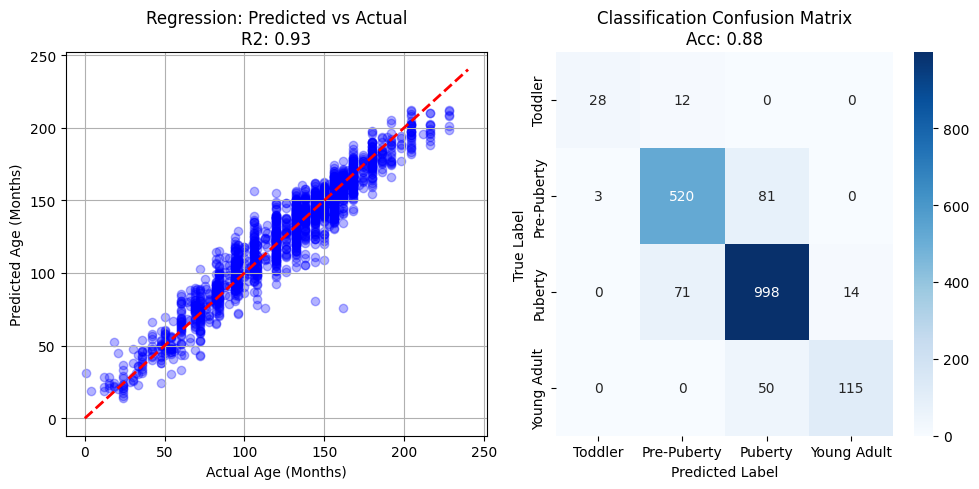

In [18]:
# ==========================================
# 7. VISUALIZATIONS
# ==========================================

# 1. Regression Scatter Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(metrics['y_true_reg'], metrics['y_pred_reg'], alpha=0.3, color='blue')
plt.plot([0, 240], [0, 240], 'r--', lw=2) # Perfect prediction line
plt.xlabel("Actual Age (Months)")
plt.ylabel("Predicted Age (Months)")
plt.title(f"Regression: Predicted vs Actual\nR2: {metrics['R2']:.2f}")
plt.grid(True)

# 2. Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Classification Confusion Matrix\nAcc: {metrics['Accuracy']:.2f}")

plt.tight_layout()
plt.show()